In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

## Section 1: Metadata

In [2]:
## Load metadata.
prolific = read_csv(os.path.join('..','prolific','data','metadata.csv'))
mturk = read_csv(os.path.join('..','mturk','data','metadata.csv'))
metadata = concat([prolific, mturk], sort=False)

## Update column names.
metadata['use-other'] = np.where(metadata.mturk.isnull(), metadata.prolific, metadata.mturk)

## Initialize reject dataframe.
reject = metadata[['platform','subject']]

#### 1.1 Study Metrics

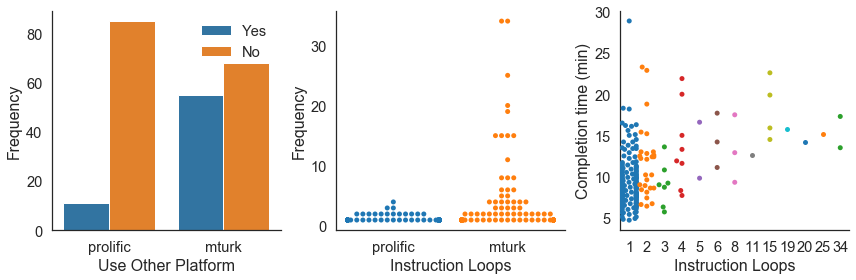

In [3]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Store instruction loops.
reject = reject.merge(metadata[['platform','subject','n_loops']])

## Plot platform use.
sns.countplot('platform', hue='use-other', data=metadata, hue_order=['Yes', 'No'], ax=axes[0])
axes[0].legend(loc=1, frameon=False)
axes[0].set(xlabel='Use Other Platform', ylabel='Frequency')

## Plot instructions loops.
sns.swarmplot('platform', 'n_loops', data=metadata, ax=axes[1])
axes[1].set(xlabel='Instruction Loops', ylabel='Frequency')

## Plot participation time.
sns.swarmplot('n_loops', 'minutes', data=metadata, palette=sns.color_palette(), ax=axes[2])
axes[2].set(xlabel='Instruction Loops', ylabel='Completion time (min)')

sns.despine()
plt.tight_layout()

## Section 2: Self-Report Data

In [4]:
## Load survey data.
prolific = read_csv(os.path.join('..','prolific','data','surveys.csv'))
mturk = read_csv(os.path.join('..','mturk','data','surveys.csv'))
surveys = concat([prolific,mturk])

#### 2.1 Infrequency Items
Following Huang et al. (2015) and Ophir et al. (2019), we included 3 infrequency items in our surveys (1 per survey). These are items with only one correct or highly probable answer. Previous research suggests that a zero-tolerance scoring of infrequency items is too severe ([Kim et al., 2018](http://dx.doi.org/10.3758/s13428-017-0964-9)), thus we will not reject based on a single improbable answer.

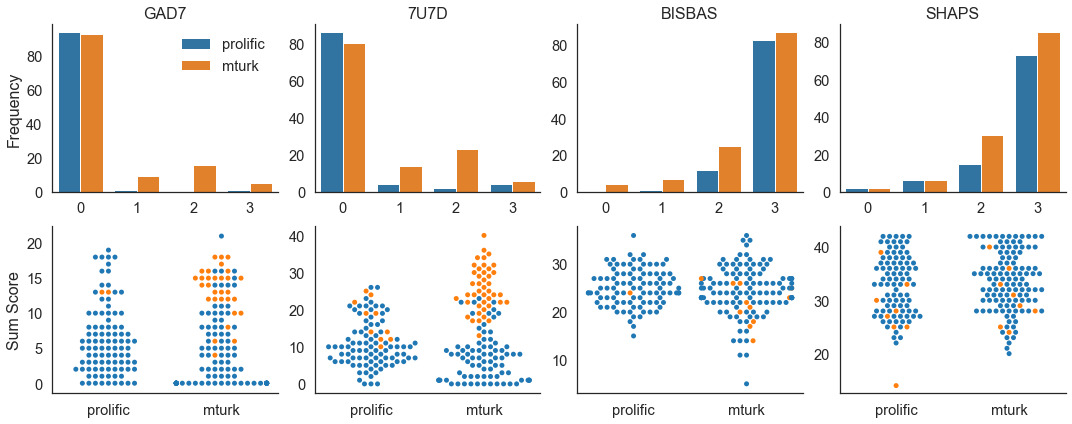

In [5]:
## Initialize canvas.
fig, axes = plt.subplots(2,4,figsize=(15,6))

## Define metadata.
prefixes = ['gad7','7u7d','bisbas','shaps']
orders = [np.arange(4), np.arange(4), np.arange(4), np.arange(4)] 
flags = [(1,2,3),(1,2,3),(0,1),(0,1)]

## Iteratively plot.
for i, (prefix, order, flag) in enumerate(zip(prefixes, orders, flags)):
    
    ## Extract survey.
    cols = ['platform','subject'] + surveys.filter(regex=f'{prefix}-q').columns.tolist()    
    items = surveys[cols].copy()
    
    ## Score infrequency item.
    items['infreq'] = np.in1d(items.values[:,-1], flag)
    reject[f'{prefix}-infreq'] = items['infreq'].values
    
    ## Compute sum scores.
    items['total'] = items[cols[2:-1]].sum(axis=1)
    
    ## Plot responses on infrequency items.
    sns.countplot(cols[-1], hue='platform', data=items, order=order, ax=axes[0,i])
    axes[0,i].legend_.set_visible(False)
    axes[0,i].set(xlabel='', ylabel='', title=prefix.upper())
        
    ## Plot distribution of scores.
    sns.swarmplot('platform', 'total', 'infreq', data=items,  ax=axes[1,i])
    axes[1,i].set(xlabel='', ylabel='')
    axes[1,i].legend_.set_visible(False)
    
    ## Add details.
    if not i: 
        axes[0,i].legend(frameon=False, loc=1)
        axes[0,i].set_ylabel('Frequency')
        axes[1,i].set_ylabel('Sum Score')

sns.despine()
plt.tight_layout()

#### 2.2 Reading Times 
Following Ophir et al. (2019), we set a a reading-speed threshold of 10 words per second. This amounts to approximately 1s per GAD-7 item (8s total), 2.5s per 7-up-7-down item (37.5s total), 1s per BIS/BAS item (13s total), and 1s per SHAPS items (15s total).



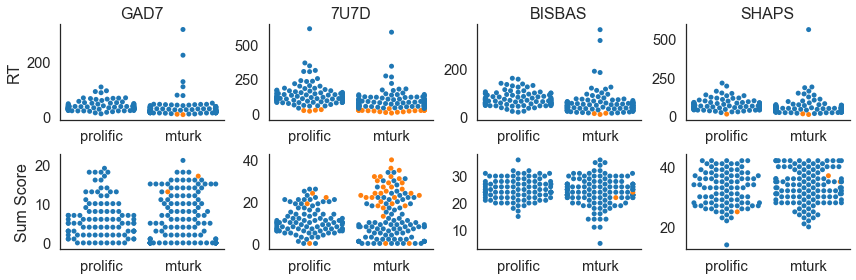

In [6]:
## Initialize canvas.
fig, axes = plt.subplots(2,4,figsize=(12,4))

## Define metadata.
prefixes = ['gad7','7u7d','bisbas','shaps']
orders = [np.arange(4), np.arange(4), np.arange(4), np.arange(4)] 
totals = [8, 37.5, 13, 15]

## Iteratively plot.
for i, (prefix, order, total) in enumerate(zip(prefixes, orders, totals)):
    
    ## Extract survey.
    cols = ['platform','subject'] + surveys.filter(regex=prefix).columns.tolist()    
    items = surveys[cols].copy()
    
    ## Score response times..
    items['rt'] = items.values[:,-1] < total
    reject[f'{prefix}-rt'] = items['rt'].values
    
    ## Compute sum scores.
    items['total'] = items[cols[2:-2]].sum(axis=1)
    
    ## Plot responses on infrequency items.
    sns.swarmplot('platform', items[cols[-1]], 'rt', data=items, ax=axes[0,i])
    axes[0,i].legend_.set_visible(False)
    axes[0,i].set(xlabel='', ylabel='', title=prefix.upper())
        
    ## Plot distribution of scores.
    sns.swarmplot('platform', 'total', 'rt', data=items,  ax=axes[1,i])
    axes[1,i].set(xlabel='', ylabel='')
    axes[1,i].legend_.set_visible(False)
    
    ## Add details.
    if not i: 
        axes[0,i].set_ylabel('RT')
        axes[1,i].set_ylabel('Sum Score')
    
sns.despine()
plt.tight_layout()

## Section 3: Behavioral Data

In [7]:
## Load survey data.
prolific = read_csv(os.path.join('..','prolific','data','data.csv'))
mturk = read_csv(os.path.join('..','mturk','data','data.csv'))
data = concat([prolific,mturk])

#### 3.1 Accuracy

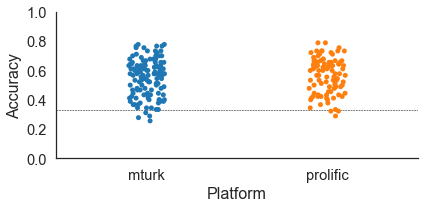

In [8]:
## Compute within-subject accuracy.
gb = data.groupby(['platform','subject']).accuracy.mean().reset_index()

## Merge with DataFrame.
reject = reject.merge(gb)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Plot scores.
sns.stripplot('platform', 'accuracy', data=gb, orient='v', ax=ax)
ax.axhline(0.33, lw=0.5, linestyle='--', color='k')
ax.set(xlabel='Platform', ylabel='Accuracy', ylim=(0,1))

sns.despine()
plt.tight_layout()

#### 3.2 Win-Stay Lose-Shift

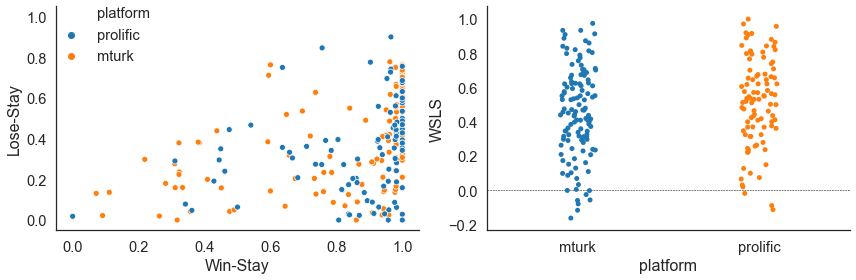

In [9]:
## Define WSLS regression.
def wsls_regression(df):
    df = df.dropna().copy()
    X = df[['intercept','prev_outcome']].dropna().values    
    y = df['stay']
    return np.linalg.lstsq(X,y,rcond=-1)[0][-1]

## Define previous outcome.
f = lambda x: np.roll(x, 1)
data['prev_outcome'] = data.groupby('subject').outcome.transform(f)
data.loc[data.trial==1,'prev_outcome'] = np.nan

## Define stay choices.
f = lambda x: (x == np.roll(x,1)).astype(int)
data['stay'] = data.groupby('subject').choice.transform(f)
data.loc[data.trial==1,'stay'] = np.nan

## Define intercept.
data['intercept'] = 1

## Compute pivot table.
pivot = data.groupby(['platform','subject','prev_outcome']).stay.mean().reset_index()
pivot = pivot.pivot_table('stay',['platform','subject'],'prev_outcome').reset_index()

## Compute WSLS coefficient.
coef = data.groupby(['platform','subject']).apply(wsls_regression).reset_index()
coef = coef.rename(columns={0:'wsls'})

## Merge with DataFrame.
reject = reject.merge(coef) 

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot WSLS rates.
sns.scatterplot(1, 0, 'platform', data=pivot, hue_order=['prolific','mturk'], ax=axes[0])
axes[0].set(xlim=(-0.05,1.05), xlabel='Win-Stay', ylim=(-0.05,1.05), ylabel='Lose-Stay')
axes[0].legend(loc=2, frameon=False, title='', borderpad=-0.5)

## Plot coefficients.
sns.stripplot('platform', 'wsls', data=coef, ax=axes[1])
axes[1].axhline(0, lw=0.5, linestyle='--', color='k')
axes[1].set(ylabel='WSLS')

sns.despine()
plt.tight_layout()